# PARTE 0
## Instalando as Bibliotecas necessárias 

In [16]:
%pip install numpy 
%pip install matplotlib
%pip install pillow


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Parte 1
### Criação e quantização do sinal
### Acrescimento de Ruido Pós quantização
### Criação dos espectros de frequência dos sinais original e quantizado
### Criação do Diagrama de olho
###### Escolha a opção 1


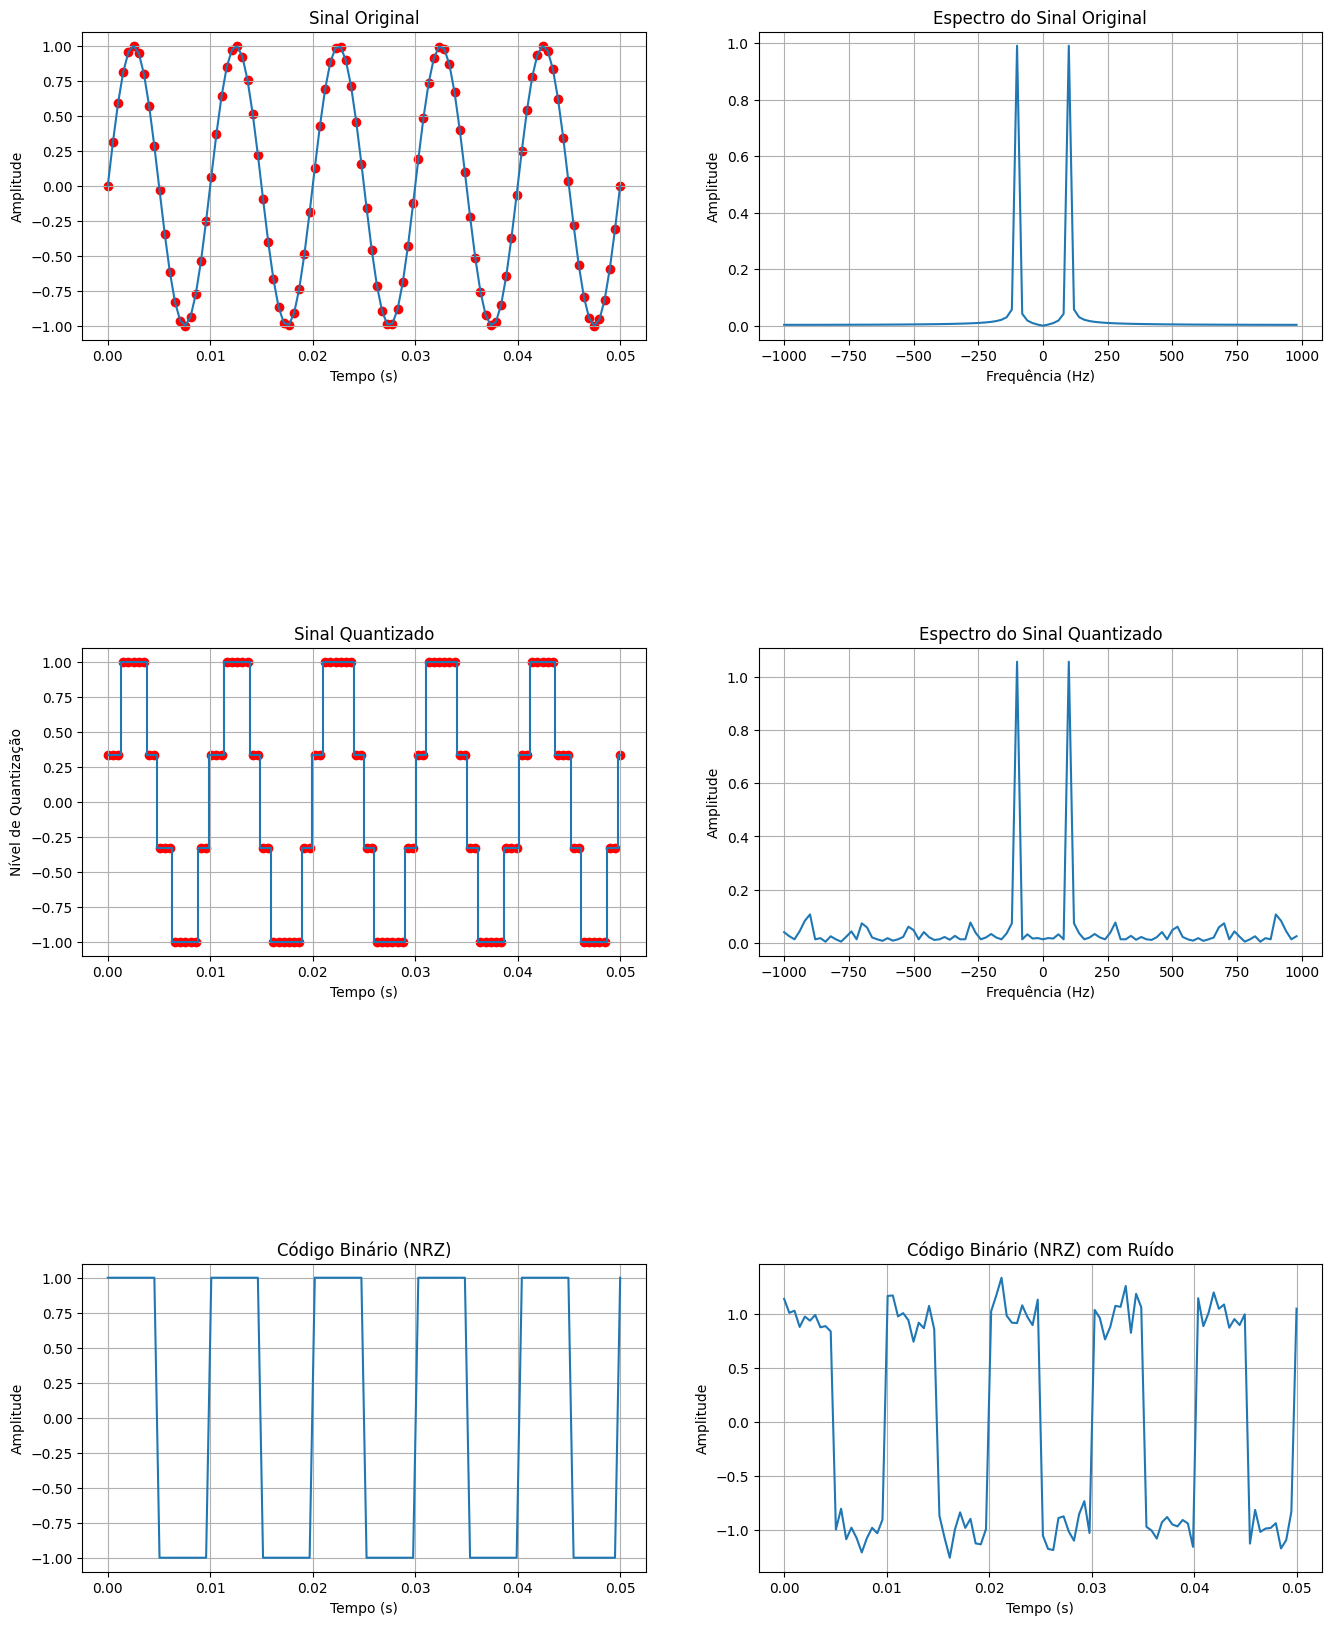

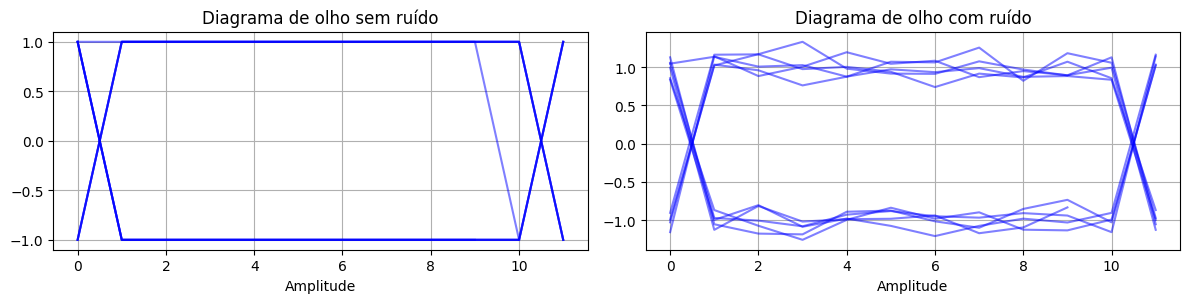

In [21]:
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from urllib.request import urlopen
from io import BytesIO

# Função para quantizar o sinal (ou imagem)
# Entrada: sinal - array numpy contendo o sinal a ser quantizado
#          num_niveis - número de níveis desejados para a quantização
# Saída: sinal_quantizado - array numpy com o sinal quantizado
#        niveis_quant - array numpy com os níveis de quantização utilizados
def quantizar_sinal(sinal, num_niveis):
    valor_min = np.min(sinal)
    valor_max = np.max(sinal)
    # Eixo Y do sinal quantizado
    niveis_quant = np.linspace(valor_min, valor_max, num_niveis)
    sinal_quantizado = np.round((sinal - valor_min) / (valor_max - valor_min) * (num_niveis - 1)) / (num_niveis - 1) * (valor_max - valor_min) + valor_min
    return sinal_quantizado, niveis_quant

# Função para gerar o código binário a partir do sinal quantizado
# Entrada: sinal_quantizado - array numpy com o sinal quantizado
#          num_niveis - número de níveis utilizados na quantização
# Saída: codigo_binario - lista de strings contendo o código binário para cada amostra do sinal quantizado
#        num_bits - número de bits utilizado para representar cada nível de quantização
def gerar_codigo_binario(sinal_quantizado, num_niveis):
    num_bits = int(np.ceil(np.log2(num_niveis)))
    codigo_binario = [
        np.binary_repr(
            int((nivel - np.min(sinal_quantizado)) * (num_niveis - 1) / (np.max(sinal_quantizado) - np.min(sinal_quantizado))), 
            width=num_bits
        ) 
        for nivel in sinal_quantizado.flatten()
    ]
    return codigo_binario, num_bits

# Função para codificar o sinal utilizando o método NRZ
# Entrada: sinal - array contendo o sinal a ser codificado
#          bin - indica se o sinal já está em formato binário (default False)
# Saída: sinal_codificado - array contendo o sinal codificado
def codificar_nrz(sinal, bin=False):
    threshold = None
    sinal_codificado = []
    values = list(set(sinal))
    pair = True
    if bin:
        # Ordena e converte os valores binários para inteiros
        values_int = sorted([int(v, 2) for v in values], reverse=True)
        if len(values_int) % 2 == 0:
            threshold = values_int[int(len(values_int)/2) - 1]
        else:
            pair = False
            threshold = values_int[int(math.floor(len(values_int)/2))]
        for i in sinal:
            if pair:
                if int(i, 2) > threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
            else:
                if int(i, 2) >= threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
    else:
        values = sorted(values)
        if len(values) % 2 == 0:
            threshold = values[int(len(values)/2) - 1]
        else:
            pair = False
            threshold = values[int(math.floor(len(values)/2))]
        for i in sinal:
            if pair:
                if i > threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
            else:
                if i >= threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
    return sinal_codificado

# Função para plotar a transformada de Fourier de uma senoide
# Entrada: ax - objeto do matplotlib para plotagem
#          signal - array contendo o sinal a ser analisado
#          sampling_rate - taxa de amostragem do sinal
#          title - título do gráfico
def plot_fft_sen(ax, signal, sampling_rate, title):
    N = len(signal)
    T = 1.0 / sampling_rate
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, T)
    
    yf_shifted = np.fft.fftshift(yf)
    xf_shifted = np.fft.fftshift(xf)
    
    ax.plot(xf_shifted, 2.0/N * np.abs(yf_shifted))
    ax.grid()
    ax.set_xlabel('Frequência (Hz)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)

# Função para plotar a transformada de Fourier de uma imagem
# Entrada: ax - objeto do matplotlib para plotagem
#          signal - array numpy contendo a imagem a ser analisada
#          title - título do gráfico
def plot_fft_img(ax, signal, title):
     # Calcula a transformada de Fourier e o espectro de magnitude
    fft_signal = np.fft.fftshift(np.fft.fft2(signal))
    magnitude_spectrum = np.abs(fft_signal)
    # Plota a imagem da magnitude do espectro com escala logarítmica

    ax.imshow(np.log(1 + magnitude_spectrum), cmap='gray')
    ax.set_title(title)
    ax.axis('off')

# Função para converter uma imagem a partir de uma URL
def converte_img():
    fails = 0
    while fails <= 2:
        try:
            url = input("Digite a URL da imagem: ")
            response = urlopen(url)
            break
        except Exception as e:
            print(f"Erro ao acessar a URL: {e}")
            fails += 1
    if fails > 2:
        raise Exception("Não foi possível acessar as URL's")
    image_bytes = BytesIO(response.read())

    # Tentar abrir a imagem especificando o formato
    try:
        img = Image.open(image_bytes).convert('L')
    except IOError:
        print("Erro ao abrir a imagem. Verifique o formato ou a URL.")
        raise Exception("Erro ao abrir a imagem. Verifique o formato ou a URL.")
    return img

 # Função para inicializar a criação da senoide       
def init_senoide():
    # Entrada de características do sinal
    potencia = float(input('Digite a potência desejada Db: '))
    amplitude = 10**(potencia / 10)
    frequencia = float(input('Digite a frequência desejada (hz): '))
    ciclos = int(input('Digite a quantidade de períodos a serem plotados: '))
    duracao = ciclos / frequencia
    amostragem = int(input('Digite a quantidade de amostras por período: '))
    taxa_amostragem = round(amostragem * frequencia)
    num_niveis = int(input('Digite a quantidade de níveis desejada: '))
    if num_niveis <= 1:
        raise ValueError("O número de níveis de quantização deve ser maior que 1.")

    # Cálculo do eixo x (tempo) nos gráficos. Foi adicionado meio período a mais para o cálculo do diagrama de olho
    tempo = np.linspace(0, duracao, int(taxa_amostragem * duracao), endpoint=True)
    
    # Cálculo do sinal original, a senóide no formato A*sen(pi*f*t)
    sinal_original = amplitude * np.sin(2 * np.pi * frequencia * tempo)

    # Entrada da relação Sinal Ruído em DB
    SNR = float(input('Digite a Relação Sinal Ruido em Db (SNR): '))
    print("\n")

    # Quantizar o sinal original ruidoso
    sinal_quantizado, _ = quantizar_sinal(sinal_original, num_niveis)

    # Gerar código binário a partir do sinal quantizado
    # codigo_binario, _ = gerar_codigo_binario(sinal_quantizado, num_niveis)
    sinal_codificado = codificar_nrz(sinal_quantizado, bin=False)
        
    # Plotando sinal original com ruído e sinal original, sinal quantizado sem ruído, sinal quantizado com ruído, código binário sem ruído, código binário com ruído e suas transformadas de Fourier
    fig = plt.figure(num="Trabalho de Sistemas de Radioenlace - Carlos e Alessandro", figsize=(16, 20))

    # Plotando o Sinal Original, o tempo é um corte do array do tempo para pegar apenas de 0 até o número de períodos, ao invés de pegar de 0 até o número de períodos mais meio período
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(tempo, sinal_original)
    ax1.set_xlabel('Tempo (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Sinal Original')
    ax1.scatter(tempo, sinal_original, color='red', label='Pontos de Amostragem')  
    ax1.set()
    ax1.grid(True)

    ax2 = plt.subplot(3, 2, 2)
    plot_fft_sen(ax2, sinal_original, taxa_amostragem, 'Espectro do Sinal Original')

    # Sinal Quantizado
    ax3 = plt.subplot(3, 2, 3)
    ax3.step(tempo, sinal_quantizado, where='mid')
    ax3.set_xlabel('Tempo (s)')
    ax3.set_ylabel('Nível de Quantização')
    ax3.set_title('Sinal Quantizado')
    ax3.scatter(tempo, sinal_quantizado, color='red', label='Pontos de Amostragem')  

    ax3.grid(True)

    ax4 = plt.subplot(3, 2, 4)
    plot_fft_sen(ax4, sinal_quantizado, taxa_amostragem, 'Espectro do Sinal Quantizado')

    # Código Binário sem Ruído
    ax5 = plt.subplot(3, 2, 5)
    ax5.set_xlabel("Tempo (s)")
    ax5.set_ylabel("Amplitude")
    ax5.set_title('Código Binário (NRZ)')
    ax5.plot(tempo, sinal_codificado)
    ax5.set()
    ax5.grid(True)
    
    # Código do sinal com ruído
    ruido_db = potencia - SNR
    ruido_linear = 10**(ruido_db/10)
    ruido_array = np.random.normal(0, np.sqrt(ruido_linear), len(tempo))
    codigo_com_ruido = [sinal_codificado[i] + ruido_array[i] for i in range(len(sinal_codificado))]
    ax6 = plt.subplot(3, 2, 6)
    ax6.set_xlabel("Tempo (s)")
    ax6.set_ylabel("Amplitude")
    ax6.set_title('Código Binário (NRZ) com Ruído')
    ax6.plot(tempo, codigo_com_ruido)
    ax6.set()
    ax6.grid(True)
    
    # plt.tight_layout()
    plt.subplots_adjust(hspace=1.0)
    plt.show()
    
    if ciclos < 2 or amostragem < 4:
        print("Não é possível calcular o diagrama de olho com um número de períodos menor que 2 ou amostras por período menor que 4")
        exit(0)
        
    ## Contando número de bits de cada olho
   # Inicializa listas para armazenar informações sobre as janelas
    janelas = []         # Lista para armazenar os índices onde ocorre transição de bit
    janelas_tuplas = []  # Lista para armazenar tuplas de índices de início e fim de cada janela

    # Percorre o sinal codificado para identificar transições de bits
    for bit in range(0, len(sinal_codificado)):
        # Verifica se o próximo bit é diferente do atual
        if bit + 1 < len(sinal_codificado):
            if sinal_codificado[bit] != sinal_codificado[bit + 1]:
                janelas.append(bit + 1)  # Adiciona o índice onde ocorre a transição de bit
            
        # Se estiver no último bit, adiciona o último índice como uma janela
        if bit == len(sinal_codificado) - 1:
            janelas.append(bit)
            
    # Inicializa variável de início da janela
    start = 0

    # Itera sobre a lista de índices de transição para criar as tuplas de janelas
    for j in range(0, len(janelas)):
        end = janelas[j]  # Define o fim da janela como o índice atual de transição
        
        # Condições para ajustar os índices de início e fim das janelas
        if janelas[j] < 2:
            pass  # Ignora se a janela começa muito cedo

        if janelas[j] + 1 <= len(sinal_codificado) - 1:
            end = janelas[j] + 1  # Se há um próximo bit, atualiza o fim da janela
        
        if start - 1 >= 0:
            start = start - 1  # Garante que o início da próxima janela não ultrapasse o índice mínimo
        
        # Adiciona a tupla de índices de início e fim da janela à lista de tuplas
        janelas_tuplas.append((start, end))
        start = janelas[j]  # Atualiza o início da próxima janela como o fim da janela atual
        
    # Plotando diagrama de olho sem ruído            
    plt.figure(num="Trabalho de Sistemas de Radioenlace - Carlos e Alessandro", figsize=(12, 8))
    olho_sem_ruido = plt.subplot(3, 2, 3)
    olho_sem_ruido.set_xlabel("Tempo (s)")
    olho_sem_ruido.set_xlabel("Amplitude")
    olho_sem_ruido.set_title("Diagrama de olho sem ruído")
    for tp in janelas_tuplas:
        array = sinal_codificado[tp[0]:tp[1]]
        if tp[0] == 0 and (sinal_codificado[tp[0]] != sinal_codificado[tp[0] -1]):
            array = np.insert(array, 0, sinal_codificado[tp[0] -1])
        olho_sem_ruido.plot(array, color='blue', alpha=0.5)        
    olho_sem_ruido.set()
    olho_sem_ruido.grid(True)
    
    # Plotando diagrama de olho com ruído
    olho_com_ruido = plt.subplot(3, 2, 4)
    olho_com_ruido.set_xlabel("Tempo (s)")
    olho_com_ruido.set_xlabel("Amplitude")
    olho_com_ruido.set_title("Diagrama de olho com ruído")
    olho_com_ruido.set()
    for tp in janelas_tuplas:
        array = codigo_com_ruido[tp[0]:tp[1]]
        if tp[0] == 0 and (codigo_com_ruido[tp[0]] != codigo_com_ruido[tp[0] -1]):
            array = np.insert(array, 0, codigo_com_ruido[tp[0] -1])
        olho_com_ruido.plot(array, color='blue', alpha=0.5)       
    olho_com_ruido.grid(True)
    
    plt.tight_layout()
    plt.show()

def init_imagem():
    img = converte_img()
    # Converter a imagem para um array numpy
    img_array = np.array(img)
    # Normalizar os valores dos pixels para o intervalo [0, 1]
    img_normalized = img_array / 255.0
    # Número de níveis de quantização desejado
    num_niveis = int(input("Digite o número de níveis de quantização: "))
    # Processar a imagem como um sinal
    img_quantizada, _ = quantizar_sinal(img_normalized, num_niveis)
    # Gerar código binário para a imagem quantizada
    codigo_binario = gerar_codigo_binario(img_quantizada, num_niveis)
    # Plotar as imagens e a transformada de Fourier
    plt.figure(figsize=(16, 8))

    # Imagem Original e sua transformada de Fourier
    plt.subplot(2, 2, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plot_fft_img(plt.gca(), img_array, 'Transformada de Fourier da Imagem Original')

    # Imagem Quantizada e sua transformada de Fourier
    plt.subplot(2, 2, 3)
    plt.imshow(img_quantizada, cmap='gray')
    plt.title(f'Imagem Quantizada com {num_niveis} níveis')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plot_fft_img(plt.gca(), img_quantizada, f'Transformada de Fourier da Imagem Quantizada com {num_niveis} níveis')

    plt.tight_layout()
    plt.show()

    # Informações sobre os bits gerados
    print(f"Número de bits por amostra: {int(np.ceil(np.log2(num_niveis)))}")
    print(f"Exemplo dos 200 primeiros valores do código binário:")
    for i in range(len(codigo_binario)):
        if isinstance(i/2, float):
            print(f"Amostra {i}: Valor quantizado: {img_quantizada.flatten()[i]} -> Código Binário: {codigo_binario[i]}")
    

if __name__ == "__main__":
    modo = int(input("Digite o tipo de entrada:\n\t1)Senoide\n\t2)Imagem\n"))
    match modo:
        case 1:
            init_senoide()
        case 2:
            init_imagem()

## PARTE 2
# Processamento de Imagem
 Escolha a opção "2" use o seguinte link 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Dog_face.png/800px-Dog_face.png' sem as aspas 
**Mesmo código da parte 2 por isso está com menos comentarios**

Copie o Output final e cole no bloco de notas para visualizar o codigo binario

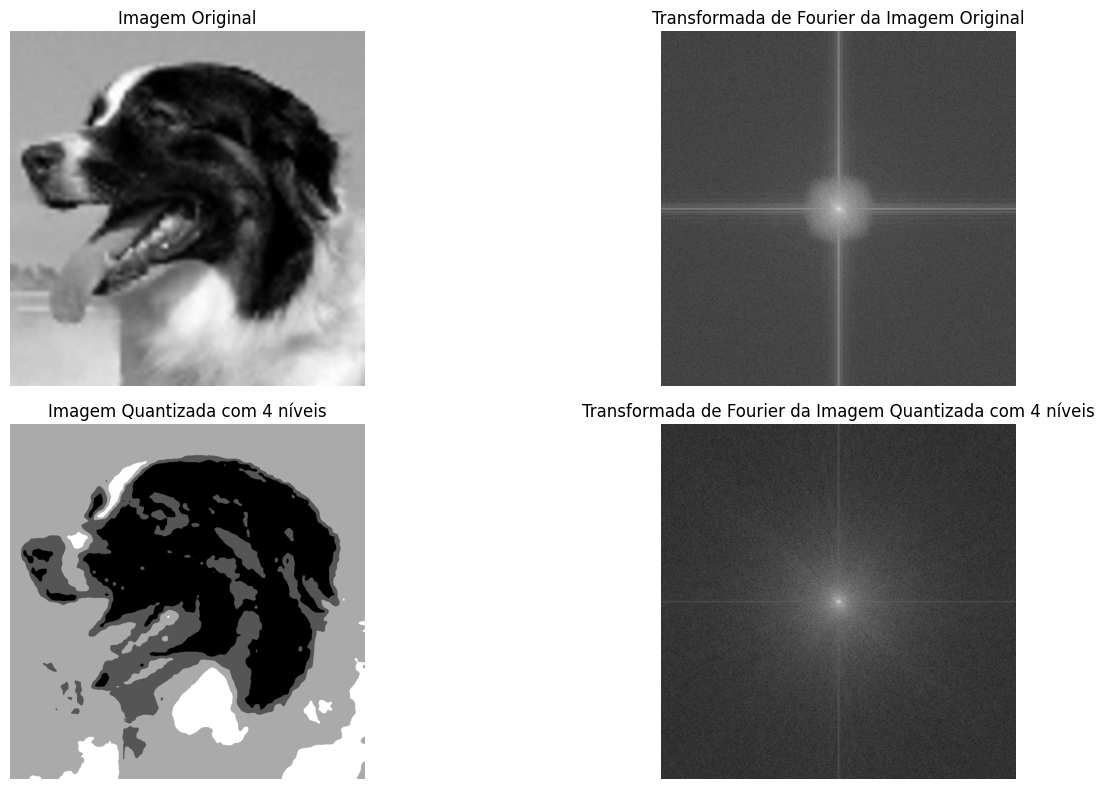

Número de bits por amostra: 2
 -> Código Binário: ['10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '

In [7]:
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from urllib.request import urlopen
from io import BytesIO

# Função para quantizar o sinal (ou imagem)
def quantizar_sinal(sinal, num_niveis):
    valor_min = np.min(sinal)
    valor_max = np.max(sinal)
    # Eixo Y do sinal quantizado
    niveis_quant = np.linspace(valor_min, valor_max, num_niveis)
    sinal_quantizado = np.round((sinal - valor_min) / (valor_max - valor_min) * (num_niveis - 1)) / (num_niveis - 1) * (valor_max - valor_min) + valor_min
    return sinal_quantizado, niveis_quant

# Função para transformar a função quantizada, para uma representação em binários
def gerar_codigo_binario(sinal_quantizado, num_niveis):
    num_bits = int(np.ceil(np.log2(num_niveis)))
    codigo_binario = [
        np.binary_repr(
            int((nivel - np.min(sinal_quantizado)) * (num_niveis - 1) / (np.max(sinal_quantizado) - np.min(sinal_quantizado))), 
            width=num_bits
        ) 
        for nivel in sinal_quantizado.flatten()
    ]
    return codigo_binario, num_bits

def codificar_nrz(sinal, bin=False):
    threshold = None
    sinal_codificado = []
    values = list(set(sinal))
    pair = True
    if bin:
        values_int = sorted([int(v, 2) for v in values], reverse=True)
        if len(values_int) % 2 == 0:
            threshold = values_int[int(len(values_int)/2) - 1]
        else:
            pair = False
            threshold = values_int[int(math.floor(len(values_int)/2))]
        for i in sinal:
            if pair:
                if int(i, 2) > threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
            else:
                if int(i, 2) >= threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
    else:
        values = sorted(values)
        if len(values) % 2 == 0:
            threshold = values[int(len(values)/2) - 1]
        else:
            pair = False
            threshold = values[int(math.floor(len(values)/2))]
        for i in sinal:
            if pair:
                if i > threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
            else:
                if i >= threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
    return sinal_codificado

# Função para plotar a transformada de Fourier da senoide
def plot_fft_sen(ax, signal, sampling_rate, title):
    N = len(signal)
    T = 1.0 / sampling_rate
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, T)
    
    yf_shifted = np.fft.fftshift(yf)
    xf_shifted = np.fft.fftshift(xf)
    
    ax.plot(xf_shifted, 2.0/N * np.abs(yf_shifted))
    ax.grid()
    ax.set_xlabel('Frequência (Hz)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)

# Função para plotar a transformada de Fourier da imagem
def plot_fft_img(ax, signal, title):
    fft_signal = np.fft.fftshift(np.fft.fft2(signal))
    magnitude_spectrum = np.abs(fft_signal)
    
    ax.imshow(np.log(1 + magnitude_spectrum), cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    
def converte_img():
    fails = 0
    while fails <= 2:
        try:
            url = input("Digite a URL da imagem: ")
            response = urlopen(url)
            break
        except Exception as e:
            print(f"Erro ao acessar a URL: {e}")
            fails += 1
    if fails > 2:
        raise Exception("Não foi possível acessar as URL's")
    image_bytes = BytesIO(response.read())

    # Tentar abrir a imagem especificando o formato
    try:
        img = Image.open(image_bytes).convert('L')
    except IOError:
        print("Erro ao abrir a imagem. Verifique o formato ou a URL.")
        raise Exception("Erro ao abrir a imagem. Verifique o formato ou a URL.")
    return img
        
def init_senoide():
    # Entrada de características do sinal
    potencia = float(input('Digite a potência desejada Db: '))
    amplitude = 10**(potencia / 10)
    frequencia = float(input('Digite a frequência desejada (hz): '))
    ciclos = int(input('Digite a quantidade de períodos a serem plotados: '))
    duracao = ciclos / frequencia
    amostragem = int(input('Digite a quantidade de amostras por período: '))
    taxa_amostragem = round(amostragem * frequencia)
    num_niveis = int(input('Digite a quantidade de níveis desejada: '))
    if num_niveis <= 1:
        raise ValueError("O número de níveis de quantização deve ser maior que 1.")

    # Cálculo do eixo x (tempo) nos gráficos. Foi adicionado meio período a mais para o cálculo do diagrama de olho
    tempo = np.linspace(0, duracao, int(taxa_amostragem * duracao), endpoint=True)
    
    # Cálculo do sinal original, a senóide no formato A*sen(pi*f*t)
    sinal_original = amplitude * np.sin(2 * np.pi * frequencia * tempo)

    # Entrada da relação Sinal Ruído em DB
    SNR = float(input('Digite a Relação Sinal Ruido em Db (SNR): '))
    print("\n")

    # Quantizar o sinal original ruidoso
    sinal_quantizado, _ = quantizar_sinal(sinal_original, num_niveis)

    # Gerar código binário a partir do sinal quantizado
    # codigo_binario, _ = gerar_codigo_binario(sinal_quantizado, num_niveis)
    sinal_codificado = codificar_nrz(sinal_quantizado, bin=False)
        
    # Plotando sinal original com ruído e sinal original, sinal quantizado sem ruído, sinal quantizado com ruído, código binário sem ruído, código binário com ruído e suas transformadas de Fourier
    fig = plt.figure(num="Trabalho de Sistemas de Radioenlace - Carlos e Alessandro", figsize=(16, 20))

    # Plotando o Sinal Original, o tempo é um corte do array do tempo para pegar apenas de 0 até o número de períodos, ao invés de pegar de 0 até o número de períodos mais meio período
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(tempo, sinal_original)
    ax1.set_xlabel('Tempo (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Sinal Original')
    ax1.set()
    ax1.grid(True)

    ax2 = plt.subplot(3, 2, 2)
    plot_fft_sen(ax2, sinal_original, taxa_amostragem, 'Espectro do Sinal Original')

    # Sinal Quantizado
    ax3 = plt.subplot(3, 2, 3)
    ax3.step(tempo, sinal_quantizado, where='mid')
    ax3.set_xlabel('Tempo (s)')
    ax3.set_ylabel('Nível de Quantização')
    ax3.set_title('Sinal Quantizado')
    ax3.grid(True)

    ax4 = plt.subplot(3, 2, 4)
    plot_fft_sen(ax4, sinal_quantizado, taxa_amostragem, 'Espectro do Sinal Quantizado')

    # Código Binário sem Ruído
    ax5 = plt.subplot(3, 2, 5)
    ax5.set_xlabel("Tempo (s)")
    ax5.set_ylabel("Amplitude")
    ax5.set_title('Código Binário (NRZ)')
    ax5.plot(tempo, sinal_codificado)
    ax5.set()
    ax5.grid(True)
    
    # Código do sinal com ruído
    ruido_db = potencia - SNR
    ruido_linear = 10**(ruido_db/10)
    ruido_array = np.random.normal(0, np.sqrt(ruido_linear), len(tempo))
    codigo_com_ruido = [sinal_codificado[i] + ruido_array[i] for i in range(len(sinal_codificado))]
    ax6 = plt.subplot(3, 2, 6)
    ax6.set_xlabel("Tempo (s)")
    ax6.set_ylabel("Amplitude")
    ax6.set_title('Código Binário (NRZ) com Ruído')
    ax6.plot(tempo, codigo_com_ruido)
    ax6.set()
    ax6.grid(True)
    
    # plt.tight_layout()
    plt.subplots_adjust(hspace=1.0)
    plt.show()
    
    if ciclos < 2 or amostragem < 4:
        print("Não é possível calcular o diagrama de olho com um número de períodos menor que 2 ou amostras por período menor que 4")
        exit(0)
        
    ## Contando número de bits de cada olho
    janelas = []
    janelas_tuplas = []
    
    for bit in range(0, len(sinal_codificado)):
        if bit + 1 < len(sinal_codificado):
            if sinal_codificado[bit] != sinal_codificado[bit + 1]:
                janelas.append(bit + 1)
        if bit == len(sinal_codificado) - 1:
            janelas.append(bit)
            
    start = 0
    for j in range(0, len(janelas)):
        end = janelas[j]
        
        if janelas[j] < 2:
            pass
        
       
        if janelas[j] + 1 <= len(sinal_codificado) - 1:
            end = janelas[j] + 1
        
        if start - 1 >= 0:
            start = start - 1
        
        janelas_tuplas.append((start, end))
        start = janelas[j]
    
    
    # Plotando diagrama de olho sem ruído            
    plt.figure(num="Trabalho de Sistemas de Radioenlace - Carlos e Alessandro", figsize=(12, 8))
    olho_sem_ruido = plt.subplot(3, 2, 3)
    olho_sem_ruido.set_xlabel("Tempo (s)")
    olho_sem_ruido.set_xlabel("Amplitude")
    olho_sem_ruido.set_title("Diagrama de olho sem ruído")
    for tp in janelas_tuplas:
        array = sinal_codificado[tp[0]:tp[1]]
        if tp[0] == 0 and (sinal_codificado[tp[0]] != sinal_codificado[tp[0] -1]):
            array = np.insert(array, 0, sinal_codificado[tp[0] -1])
        olho_sem_ruido.plot(array, color='blue', alpha=0.5)        
    olho_sem_ruido.set()
    olho_sem_ruido.grid(True)
    
    # Plotando diagrama de olho com ruído
    olho_com_ruido = plt.subplot(3, 2, 4)
    olho_com_ruido.set_xlabel("Tempo (s)")
    olho_com_ruido.set_xlabel("Amplitude")
    olho_com_ruido.set_title("Diagrama de olho com ruído")
    olho_com_ruido.set()
    for tp in janelas_tuplas:
        array = codigo_com_ruido[tp[0]:tp[1]]
        if tp[0] == 0 and (codigo_com_ruido[tp[0]] != codigo_com_ruido[tp[0] -1]):
            array = np.insert(array, 0, codigo_com_ruido[tp[0] -1])
        olho_com_ruido.plot(array, color='blue', alpha=0.5)       
    olho_com_ruido.grid(True)
    
    plt.tight_layout()
    plt.show()

def init_imagem():
    img = converte_img()
    # Converter a imagem para um array numpy
    img_array = np.array(img)
    # Normalizar os valores dos pixels para o intervalo [0, 1]
    img_normalized = img_array / 255.0
    # Número de níveis de quantização desejado
    num_niveis = int(input("Digite o número de níveis de quantização: "))
    # Processar a imagem como um sinal
    img_quantizada, _ = quantizar_sinal(img_normalized, num_niveis)
    # Gerar código binário para a imagem quantizada
    codigo_binario = gerar_codigo_binario(img_quantizada, num_niveis)
    # Plotar as imagens e a transformada de Fourier
    plt.figure(figsize=(16, 8))

    # Imagem Original e sua transformada de Fourier
    plt.subplot(2, 2, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plot_fft_img(plt.gca(), img_array, 'Transformada de Fourier da Imagem Original')

    # Imagem Quantizada e sua transformada de Fourier
    plt.subplot(2, 2, 3)
    plt.imshow(img_quantizada, cmap='gray')
    plt.title(f'Imagem Quantizada com {num_niveis} níveis')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plot_fft_img(plt.gca(), img_quantizada, f'Transformada de Fourier da Imagem Quantizada com {num_niveis} níveis')

    plt.tight_layout()
    plt.show()

    # Informações sobre os bits gerados
    print(f"Número de bits por amostra: {int(np.ceil(np.log2(num_niveis)))}")
    for i in range(min(100,len(codigo_binario))):
        if isinstance(i/2, float):
            print(f" -> Código Binário: {codigo_binario[i]}")

if __name__ == "__main__":
    modo = int(input("Digite o tipo de entrada:\n\t1)Senoide\n\t2)Imagem\n"))
    match modo:
        case 1:
            init_senoide()
        case 2:
            init_imagem()

# Apendice
codigo abaixo para rodar em formato ".py"

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from urllib.request import urlopen
from io import BytesIO

# Função para quantizar o sinal (ou imagem)
def quantizar_sinal(sinal, num_niveis):
    valor_min = np.min(sinal)
    valor_max = np.max(sinal)
    # Eixo Y do sinal quantizado
    niveis_quant = np.linspace(valor_min, valor_max, num_niveis)
    sinal_quantizado = np.round((sinal - valor_min) / (valor_max - valor_min) * (num_niveis - 1)) / (num_niveis - 1) * (valor_max - valor_min) + valor_min
    return sinal_quantizado, niveis_quant

# Função para transformar a função quantizada, para uma representação em binários
def gerar_codigo_binario(sinal_quantizado, num_niveis):
    num_bits = int(np.ceil(np.log2(num_niveis)))
    codigo_binario = [
        np.binary_repr(
            int((nivel - np.min(sinal_quantizado)) * (num_niveis - 1) / (np.max(sinal_quantizado) - np.min(sinal_quantizado))), 
            width=num_bits
        ) 
        for nivel in sinal_quantizado.flatten()
    ]
    return codigo_binario, num_bits

def codificar_nrz(sinal, bin=False):
    threshold = None
    sinal_codificado = []
    values = list(set(sinal))
    pair = True
    if bin:
        values_int = sorted([int(v, 2) for v in values], reverse=True)
        if len(values_int) % 2 == 0:
            threshold = values_int[int(len(values_int)/2) - 1]
        else:
            pair = False
            threshold = values_int[int(math.floor(len(values_int)/2))]
        for i in sinal:
            if pair:
                if int(i, 2) > threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
            else:
                if int(i, 2) >= threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
    else:
        values = sorted(values)
        if len(values) % 2 == 0:
            threshold = values[int(len(values)/2) - 1]
        else:
            pair = False
            threshold = values[int(math.floor(len(values)/2))]
        for i in sinal:
            if pair:
                if i > threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
            else:
                if i >= threshold:
                    sinal_codificado.append(1)
                else:
                    sinal_codificado.append(-1)
    return sinal_codificado

# Função para plotar a transformada de Fourier da senoide
def plot_fft_sen(ax, signal, sampling_rate, title):
    N = len(signal)
    T = 1.0 / sampling_rate
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, T)
    
    yf_shifted = np.fft.fftshift(yf)
    xf_shifted = np.fft.fftshift(xf)
    
    ax.plot(xf_shifted, 2.0/N * np.abs(yf_shifted))
    ax.grid()
    ax.set_xlabel('Frequência (Hz)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)

# Função para plotar a transformada de Fourier da imagem
def plot_fft_img(ax, signal, title):
    fft_signal = np.fft.fftshift(np.fft.fft2(signal))
    magnitude_spectrum = np.abs(fft_signal)
    
    ax.imshow(np.log(1 + magnitude_spectrum), cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    
def converte_img():
    fails = 0
    while fails <= 2:
        try:
            url = input("Digite a URL da imagem: ")
            response = urlopen(url)
            break
        except Exception as e:
            print(f"Erro ao acessar a URL: {e}")
            fails += 1
    if fails > 2:
        raise Exception("Não foi possível acessar as URL's")
    image_bytes = BytesIO(response.read())

    # Tentar abrir a imagem especificando o formato
    try:
        img = Image.open(image_bytes).convert('L')
    except IOError:
        print("Erro ao abrir a imagem. Verifique o formato ou a URL.")
        raise Exception("Erro ao abrir a imagem. Verifique o formato ou a URL.")
    return img
        
def init_senoide():
    # Entrada de características do sinal
    potencia = float(input('Digite a potência desejada Db: '))
    amplitude = 10**(potencia / 10)
    frequencia = float(input('Digite a frequência desejada (hz): '))
    ciclos = int(input('Digite a quantidade de períodos a serem plotados: '))
    duracao = ciclos / frequencia
    amostragem = int(input('Digite a quantidade de amostras por período: '))
    taxa_amostragem = round(amostragem * frequencia)
    num_niveis = int(input('Digite a quantidade de níveis desejada: '))
    if num_niveis <= 1:
        raise ValueError("O número de níveis de quantização deve ser maior que 1.")

    # Cálculo do eixo x (tempo) nos gráficos. Foi adicionado meio período a mais para o cálculo do diagrama de olho
    tempo = np.linspace(0, duracao, int(taxa_amostragem * duracao), endpoint=True)
    
    # Cálculo do sinal original, a senóide no formato A*sen(pi*f*t)
    sinal_original = amplitude * np.sin(2 * np.pi * frequencia * tempo)

    # Entrada da relação Sinal Ruído em DB
    SNR = float(input('Digite a Relação Sinal Ruido em Db (SNR): '))
    print("\n")

    # Quantizar o sinal original ruidoso
    sinal_quantizado, _ = quantizar_sinal(sinal_original, num_niveis)

    # Gerar código binário a partir do sinal quantizado
    # codigo_binario, _ = gerar_codigo_binario(sinal_quantizado, num_niveis)
    sinal_codificado = codificar_nrz(sinal_quantizado, bin=False)
        
    # Plotando sinal original com ruído e sinal original, sinal quantizado sem ruído, sinal quantizado com ruído, código binário sem ruído, código binário com ruído e suas transformadas de Fourier
    fig = plt.figure(num="Trabalho de Sistemas de Radioenlace - Carlos e Alessandro", figsize=(16, 20))

    # Plotando o Sinal Original, o tempo é um corte do array do tempo para pegar apenas de 0 até o número de períodos, ao invés de pegar de 0 até o número de períodos mais meio período
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(tempo, sinal_original)
    ax1.set_xlabel('Tempo (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Sinal Original')
    ax1.set()
    ax1.grid(True)

    ax2 = plt.subplot(3, 2, 2)
    plot_fft_sen(ax2, sinal_original, taxa_amostragem, 'Espectro do Sinal Original')

    # Sinal Quantizado
    ax3 = plt.subplot(3, 2, 3)
    ax3.step(tempo, sinal_quantizado, where='mid')
    ax3.set_xlabel('Tempo (s)')
    ax3.set_ylabel('Nível de Quantização')
    ax3.set_title('Sinal Quantizado')
    ax3.grid(True)

    ax4 = plt.subplot(3, 2, 4)
    plot_fft_sen(ax4, sinal_quantizado, taxa_amostragem, 'Espectro do Sinal Quantizado')

    # Código Binário sem Ruído
    ax5 = plt.subplot(3, 2, 5)
    ax5.set_xlabel("Tempo (s)")
    ax5.set_ylabel("Amplitude")
    ax5.set_title('Código Binário (NRZ)')
    ax5.plot(tempo, sinal_codificado)
    ax5.set()
    ax5.grid(True)
    
    # Código do sinal com ruído
    ruido_db = potencia - SNR
    ruido_linear = 10**(ruido_db/10)
    ruido_array = np.random.normal(0, np.sqrt(ruido_linear), len(tempo))
    codigo_com_ruido = [sinal_codificado[i] + ruido_array[i] for i in range(len(sinal_codificado))]
    ax6 = plt.subplot(3, 2, 6)
    ax6.set_xlabel("Tempo (s)")
    ax6.set_ylabel("Amplitude")
    ax6.set_title('Código Binário (NRZ) com Ruído')
    ax6.plot(tempo, codigo_com_ruido)
    ax6.set()
    ax6.grid(True)
    
    # plt.tight_layout()
    plt.subplots_adjust(hspace=1.0)
    plt.show()
    
    if ciclos < 2 or amostragem < 4:
        print("Não é possível calcular o diagrama de olho com um número de períodos menor que 2 ou amostras por período menor que 4")
        exit(0)
        
    ## Contando número de bits de cada olho
    janelas = []
    janelas_tuplas = []
    
    for bit in range(0, len(sinal_codificado)):
        if bit + 1 < len(sinal_codificado):
            if sinal_codificado[bit] != sinal_codificado[bit + 1]:
                janelas.append(bit + 1)
        if bit == len(sinal_codificado) - 1:
            janelas.append(bit)
            
    start = 0
    for j in range(0, len(janelas)):
        end = janelas[j]
        
        if janelas[j] < 2:
            pass
        
        if janelas[j] + 1 <= len(sinal_codificado) - 1:
            end = janelas[j] + 1
        
        if start - 1 >= 0:
            start = start - 1
        
        janelas_tuplas.append((start, end))
        start = janelas[j]

    # Plotando diagrama de olho sem ruído            
    plt.figure(num="Trabalho de Sistemas de Radioenlace - Carlos e Alessandro", figsize=(12, 8))
    olho_sem_ruido = plt.subplot(3, 2, 3)
    olho_sem_ruido.set_xlabel("Tempo (s)")
    olho_sem_ruido.set_xlabel("Amplitude")
    olho_sem_ruido.set_title("Diagrama de olho sem ruído")
    for tp in janelas_tuplas:
        array = sinal_codificado[tp[0]:tp[1]]
        if tp[0] == 0 and (sinal_codificado[tp[0]] != sinal_codificado[tp[0] -1]):
            array = np.insert(array, 0, sinal_codificado[tp[0] -1])
        olho_sem_ruido.plot(array, color='blue', alpha=0.5)        
    olho_sem_ruido.set()
    olho_sem_ruido.grid(True)
    
    # Plotando diagrama de olho com ruído
    olho_com_ruido = plt.subplot(3, 2, 4)
    olho_com_ruido.set_xlabel("Tempo (s)")
    olho_com_ruido.set_xlabel("Amplitude")
    olho_com_ruido.set_title("Diagrama de olho com ruído")
    olho_com_ruido.set()
    for tp in janelas_tuplas:
        array = codigo_com_ruido[tp[0]:tp[1]]
        if tp[0] == 0 and (codigo_com_ruido[tp[0]] != codigo_com_ruido[tp[0] -1]):
            array = np.insert(array, 0, codigo_com_ruido[tp[0] -1])
        olho_com_ruido.plot(array, color='blue', alpha=0.5)       
    olho_com_ruido.grid(True)
    
    plt.tight_layout()
    plt.show()

def init_imagem():
    img = converte_img()
    # Converter a imagem para um array numpy
    img_array = np.array(img)
    # Normalizar os valores dos pixels para o intervalo [0, 1]
    img_normalized = img_array / 255.0
    # Número de níveis de quantização desejado
    num_niveis = int(input("Digite o número de níveis de quantização: "))
    # Processar a imagem como um sinal
    img_quantizada, _ = quantizar_sinal(img_normalized, num_niveis)
    # Gerar código binário para a imagem quantizada
    codigo_binario = gerar_codigo_binario(img_quantizada, num_niveis)
    # Plotar as imagens e a transformada de Fourier
    plt.figure(figsize=(16, 8))

    # Imagem Original e sua transformada de Fourier
    plt.subplot(2, 2, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plot_fft_img(plt.gca(), img_array, 'Transformada de Fourier da Imagem Original')

    # Imagem Quantizada e sua transformada de Fourier
    plt.subplot(2, 2, 3)
    plt.imshow(img_quantizada, cmap='gray')
    plt.title(f'Imagem Quantizada com {num_niveis} níveis')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plot_fft_img(plt.gca(), img_quantizada, f'Transformada de Fourier da Imagem Quantizada com {num_niveis} níveis')

    plt.tight_layout()
    plt.show()

    # Informações sobre os bits gerados
    print(f"Número de bits por amostra: {int(np.ceil(np.log2(num_niveis)))}")
    print(f"Exemplo dos 200 primeiros valores do código binário:")
    for i in range(len(codigo_binario)):
        if isinstance(i/2, float):
            print(f"Amostra {i}: Valor quantizado: {img_quantizada.flatten()[i]} -> Código Binário: {codigo_binario[i]}")
    

if _name_ == "_main_":
    modo = int(input("Digite o tipo de entrada:\n\t1)Senoide\n\t2)Imagem\n"))
    match modo:
        case 1:
            init_senoide()
        case 2:
            init_imagem()